In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

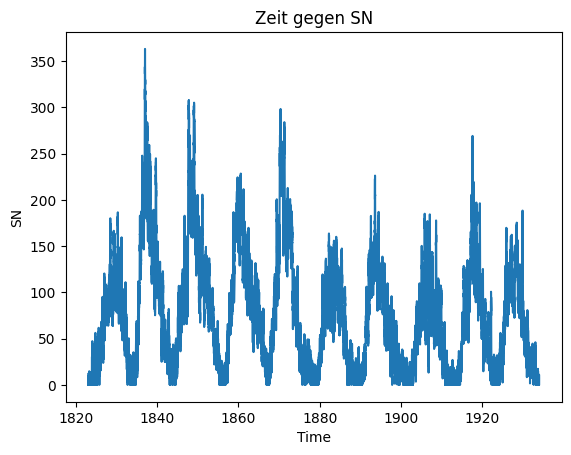

In [34]:
# Daten laden
data = pd.read_csv('data_team8.csv')

# Plot erstellen
plt.plot(data['Time'], data['SN'])
plt.xlabel('Time')
plt.ylabel('SN')
plt.title('Zeit gegen SN')
plt.show()


## Simulated Annealing (SA) Algorithm

In [3]:
# Simulated Annealing Algorithmus
def simulated_annealing(objective_function, initial_params, T0, sigma, max_iterations):
    """
    Simulated Annealing Algorithmus.
    :param objective_function: Funktion, die optimiert werden soll (z. B. MSE).
    :param initial_params: Startwerte der Parameter.
    :param T0: Anfangstemperatur.
    :param sigma: Standardabweichung für Zufallsbewegungen.
    :param max_iterations: Maximale Anzahl an Iterationen.
    :return: Optimierte Parameter und Verlauf der Kostenfunktion.
    """
    params = np.array(initial_params)
    best_params = params.copy()
    best_cost = objective_function(params)
    current_cost = best_cost
    temperature = T0
    cost_history = [best_cost]
    
    for iteration in range(max_iterations):
        # Zufällige Änderung der Parameter
        new_params = params + sigma * np.random.randn(len(params))
        new_cost = objective_function(new_params)
        
        # Akzeptanzkriterium
        if new_cost < current_cost or np.random.rand() < np.exp(-(new_cost - current_cost) / temperature):
            params = new_params
            current_cost = new_cost
            
        # Update der besten gefundenen Lösung
        if new_cost < best_cost:
            best_params = new_params
            best_cost = new_cost
        
        # Temperatur reduzieren
        temperature *= 0.99
        cost_history.append(current_cost)
    
    return best_params, cost_history


# Hyperparameter optimisation

In [11]:
# Dummy-MSE-Funktion für Testzwecke
def mse_function(params):
    return np.sum((params - np.arange(len(params)))**2)

# Starte Hyperparameteroptimierung
T0_values = [10, 50, 100]
sigma_values = [0.1, 0.5, 1.0]
best_hyperparams = None
best_cost = float('inf')

for T0 in T0_values:
    for sigma in sigma_values:
        params = np.random.rand(30)  # 30 freie Parameter
        optimised_params, cost_history = simulated_annealing(
            objective_function=mse_function,
            initial_params=params,
            T0=T0,
            sigma=sigma,
            max_iterations=1000
        )
        final_cost = cost_history[-1]
        print(f"T0: {T0}, Sigma: {sigma}, Final Cost: {final_cost}")
        if final_cost < best_cost:
            best_cost = final_cost
            best_hyperparams = (T0, sigma)

print(f"Beste Hyperparameter: T0 = {best_hyperparams[0]}, Sigma = {best_hyperparams[1]}")


T0: 10, Sigma: 0.1, Final Cost: 2842.2337849871774
T0: 10, Sigma: 0.5, Final Cost: 12.018408025009327
T0: 10, Sigma: 1.0, Final Cost: 37.509816740923995
T0: 50, Sigma: 0.1, Final Cost: 2971.5569586378156
T0: 50, Sigma: 0.5, Final Cost: 10.41479934394949
T0: 50, Sigma: 1.0, Final Cost: 39.70251690595186
T0: 100, Sigma: 0.1, Final Cost: 3449.252101763525
T0: 100, Sigma: 0.5, Final Cost: 9.32295216506622
T0: 100, Sigma: 1.0, Final Cost: 38.97878058827754
Beste Hyperparameter: T0 = 100, Sigma = 0.5


# Model calibration

Optimierte Parameter: [0.91338268 0.35012135 0.01587403 0.40099339 0.26232975 0.66291226
 0.83170199 0.73593621 0.07692744 0.86396754 0.72871378 0.33281273
 0.37463412 0.41755016 0.64871434 0.74900952 0.3813688  0.59514562
 0.23570058 0.68666284 0.78750386 0.36215855 0.99795193 0.78686255
 0.05789423 0.82749987 0.51043756 0.36472495 0.96942856 0.7788777 ]


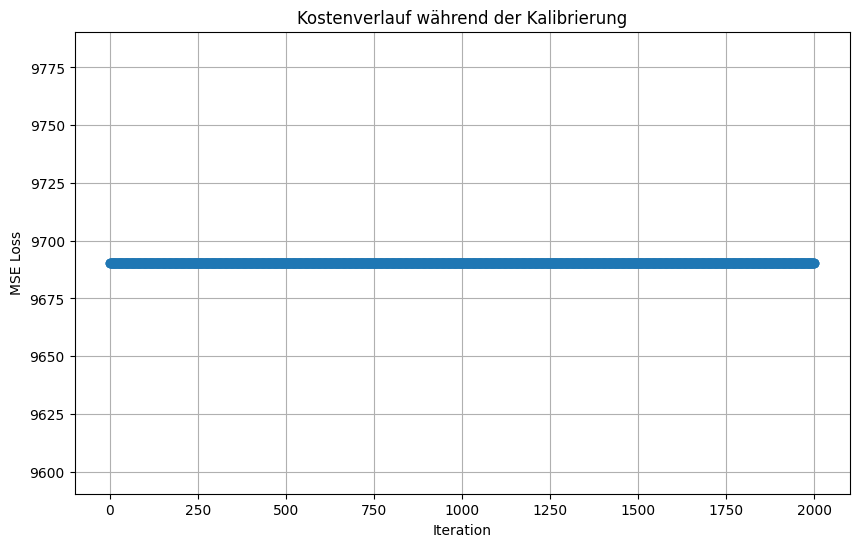

In [12]:
# Modellverlustfunktion (MSE)
def model_loss(params):
    prediction = np.zeros_like(time_data)
    for i in range(10):  # 10 Zyklen
        T0k, TS, Tdk = params[3*(i):(i+1)*3]
        prediction += ((time_data - T0k) / TS)**2 * np.exp(-((time_data - T0k) / Tdk)**2)
    mse = np.mean((sn_data - prediction)**2)  # MSE berechnen
    return mse

# Startparameter für Simulated Annealing
T0 = 500  # Höhere Anfangstemperatur
sigma = 1.0  # Größere Schrittweite
initial_params = np.random.uniform(0, 1, 30)  # Werte zwischen 0 und 1

# Simulierte Abkühlung durchführen
optimised_params, cost_history = simulated_annealing(
    objective_function=model_loss,
    initial_params=initial_params,
    T0=T0,
    sigma=sigma,
    max_iterations=2000
)

# Optimierte Parameter und Kostenverlauf ausgeben
print(f"Optimierte Parameter: {optimised_params}")

# Erstelle den Plot und begrenze die y-Achse für bessere Sichtbarkeit
plt.figure(figsize=(10, 6))
plt.plot(cost_history, marker='o')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.title('Kostenverlauf während der Kalibrierung')
plt.ylim(min(cost_history) - 100, max(cost_history) + 100)  # Dynamische Begrenzung der y-Achse
plt.grid(True)
plt.show()



# Linear Regression

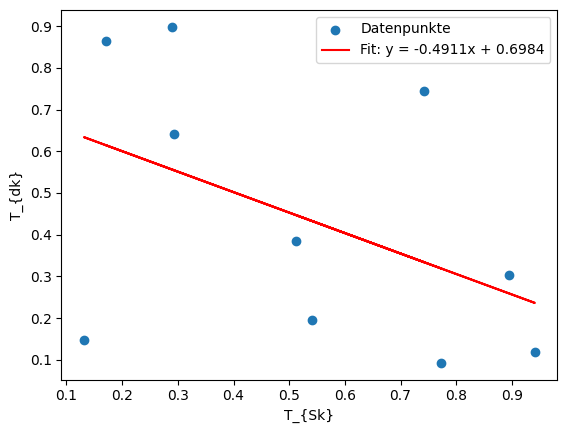

Steigung: -0.4910604404517687, Achsenabschnitt: 0.6983868531677776


In [35]:
# Extrahiere T_{Sk} und T_{dk}
Ts = optimised_params[1::3]  # T_{Sk}
Td = optimised_params[2::3]  # T_{dk}

# Lineare Regression
slope, intercept = np.polyfit(Ts, Td, 1)
Td_fit = slope * Ts + intercept

# Plot
plt.scatter(Ts, Td, label="Datenpunkte")
plt.plot(Ts, Td_fit, color="red", label=f"Fit: y = {slope:.4f}x + {intercept:.4f}")
plt.xlabel("T_{Sk}")
plt.ylabel("T_{dk}")
plt.legend()
plt.show()

print(f"Steigung: {slope}, Achsenabschnitt: {intercept}")


# Parallelisation

In [ ]:
# Parallele SA-Läufe
def parallel_sa(seed):
    np.random.seed(seed)
    initial_params = np.random.rand(30)
    return simulated_annealing(
        objective_function=model_loss,
        initial_params=initial_params,
        T0=T0,
        sigma=sigma,
        max_iterations=1000
    )[0]

with Pool(processes=4) as pool:  # 4 parallele Prozesse
    results = pool.map(parallel_sa, range(4))

# Mittelwert der Ergebnisse berechnen (Center of Mass)
best_params = np.mean(results, axis=0)
print(f"Beste Parameter (Center of Mass): {best_params}")
